<a href="https://colab.research.google.com/github/raymondEDS/iFind_tech_team/blob/raymond-colabs/clip_matching/Clip_similiarty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This script is meant to match clips with the longer raw footage. The bases of the code is from: https://aws.amazon.com/blogs/media/metfc-automatically-compare-two-videos-to-find-common-content/

In [ ]:
!pwd

/content


In [ ]:
#import libraries
import numpy as np
import pandas as pd
import cv2 as cv 
from google.colab.patches import cv2_imshow # for image display
from skimage import io
from PIL import Image 
import matplotlib.pylab as plt
from tqdm import tqdm 
from google.colab import files
from IPython.display import clear_output 
import os

!git clone https://github.com/XniceCraft/ffmpeg-colab.git
!chmod 755 ./ffmpeg-colab/install
!./ffmpeg-colab/install
print('Installation finished!')
!rm -fr /content/ffmpeg-colab
!ffmpeg -version
clear_output()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


*Remember* to mount drive first.

The path to the entire raw file is:
/content/drive/MyDrive/ifind/Raw Footage/Dyad and Family /UI006/UI006.mp4


Path to clip is:
/content/drive/MyDrive/ifind/Training Video/1 FIND Unedited Clips/1. Sharing the Focus/UI006USF.mp4


Your paths might be different.

# Matching clips based on first image of target clip

In [ ]:
def clip_length(path):
  #takes in video path as input
  #returns number of frames and video duration in milliseconds 
  cap = cv.VideoCapture(path)
  frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
  fps = int(cap.get(cv.CAP_PROP_FPS))
  seconds = frames / fps
  milliseconds = seconds * 1000
  #print(frames)
  #print(milliseconds)
  return frames, milliseconds


def first_frame_of_clip(path):
  #input path to the clip, return image of first frame
  clip_obj = cv.VideoCapture(path)
  success, image = clip_obj.read()
  return image

def getPSNR(I1, I2):
  #https://docs.opencv.org/4.x/d5/dc4/tutorial_video_input_psnr_ssim.html
  #returns psnr (Peak signal-to-noise ratio)
    s1 = cv.absdiff(I1, I2) #|I1 - I2|
    s1 = np.float32(s1)     # cannot make a square on 8 bits
    s1 = s1 * s1            # |I1 - I2|^2
    sse = s1.sum()          # sum elements per channel
    if sse <= 1e-10:        # sum channels
        return 0            # for small values return zero
    else:
        shape = I1.shape
        mse = 1.0 * sse / (shape[0] * shape[1] * shape[2])
        psnr = 10.0 * np.log10((255 * 255) / mse)
        return psnr

def getMSSISM(i1, i2):
    #https://docs.opencv.org/4.x/d5/dc4/tutorial_video_input_psnr_ssim.html
    C1 = 6.5025
    C2 = 58.5225
    # INITS
    I1 = np.float32(i1) # cannot calculate on one byte large values
    I2 = np.float32(i2)
    I2_2 = I2 * I2 # I2^2
    I1_2 = I1 * I1 # I1^2
    I1_I2 = I1 * I2 # I1 * I2
    # END INITS
    # PRELIMINARY COMPUTING
    mu1 = cv.GaussianBlur(I1, (11, 11), 1.5)
    mu2 = cv.GaussianBlur(I2, (11, 11), 1.5)
    mu1_2 = mu1 * mu1
    mu2_2 = mu2 * mu2
    mu1_mu2 = mu1 * mu2
    sigma1_2 = cv.GaussianBlur(I1_2, (11, 11), 1.5)
    sigma1_2 -= mu1_2
    sigma2_2 = cv.GaussianBlur(I2_2, (11, 11), 1.5)
    sigma2_2 -= mu2_2
    sigma12 = cv.GaussianBlur(I1_I2, (11, 11), 1.5)
    sigma12 -= mu1_mu2
    t1 = 2 * mu1_mu2 + C1
    t2 = 2 * sigma12 + C2
    t3 = t1 * t2                    # t3 = ((2*mu1_mu2 + C1).*(2*sigma12 + C2))
    t1 = mu1_2 + mu2_2 + C1
    t2 = sigma1_2 + sigma2_2 + C2
    t1 = t1 * t2                    # t1 =((mu1_2 + mu2_2 + C1).*(sigma1_2 + sigma2_2 + C2))
    ssim_map = cv.divide(t3, t1)    # ssim_map =  t3./t1;
    mssim = cv.mean(ssim_map)       # mssim = average of ssim map
    return mssim

def resize_image_wrapper(image,dim=(640,360)):
  resized_image = cv.resize(image, (640,360), interpolation = cv.INTER_AREA)
  return resized_image



def find_match_start(raw_video_path, dict_clips, testing = False):
  #dict_clips must be in the format of {key:image} key = name of serve and return element
  #returns df of the labels based on each frame
  raw_video = cv.VideoCapture(raw_video_path)
  trigger, image = raw_video.read()
  out=[]
  count= 0
  while trigger:
    d = {}
    image = resize_image_wrapper(image)
    #print('passed')
    d['count'] = count
    d['timestamp'] = raw_video.get(cv.CAP_PROP_POS_MSEC)
    for key, clip in dict_clips.items():
      #print(clip)
      clip = resize_image_wrapper(clip)
      #print('passed2')
      d['PSNR_'+ key] = getPSNR(image,clip)
      #d['MSSISM'+ key] = getMSSISM(image,clip)
      if getPSNR(image,clip) >= 30:
        d['match_'+key] = key
      else:
        d['match_'+key] = ''
    out.append(d)
    trigger, image = raw_video.read()
    count += 1
    #print(count)
    if testing:
      if count > 100:
        break

  df = pd.DataFrame(out)
  return df



In [ ]:
trial_id = "UI006"

raw_footage_path = '/content/drive/MyDrive/ifind/Raw Footage/Dyad and Family /' + trial_id + '/' + trial_id +'.mp4'
clip_path_sharing_focus ='/content/drive/MyDrive/ifind/Training Video/1 FIND Unedited Clips/1. Sharing the Focus/' + trial_id + 'USF.mp4'
clip_path_supporting_encouraging = '/content/drive/MyDrive/ifind/Training Video/1 FIND Unedited Clips/2. Supporting and Encouraging/' + trial_id + 'USE.mp4'
clip_path_naming = '/content/drive/MyDrive/ifind/Training Video/1 FIND Unedited Clips/3. Naming/' + trial_id + 'UNM.mp4'
clip_path_back_forth = '/content/drive/MyDrive/ifind/Training Video/1 FIND Unedited Clips/4. Back and Forth/' + trial_id + 'UBF.mp4'
clip_path_ending_beginnings = '/content/drive/MyDrive/ifind/Training Video/1 FIND Unedited Clips/5. Endings and Beginnings/' + trial_id + 'UEB.mp4'



image1 = first_frame_of_clip(clip_path_sharing_focus)
image2 = first_frame_of_clip(clip_path_supporting_encouraging)
image3 = first_frame_of_clip(clip_path_naming)
image4 = first_frame_of_clip(clip_path_back_forth)
image5 = first_frame_of_clip(clip_path_ending_beginnings)

In [ ]:
clips = {'share_focus': image1, 'support':image2,'naming':image3,'back_forth':image4,'ending_beginning':image5}

for key, clip in clips.items():
  print(key)
  cv2_imshow(clip)

NOTES:
1) The is really difficult to audit the generated labels to the real clips. This might suggest that human labeling is not that accurate to begin with.


In [ ]:
#CAUTION THIS WILL TAKE FOREVER (forever being like 10 minutes)
df = find_match_start(raw_footage_path,clips)
df.to_csv('UI006_labels.csv', encoding = 'utf-8-sig') 
files.download("UI006_labels.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

test = "/content/drive/MyDrive/ifind/Training Video/1 FIND Unedited Clips/1. Sharing the Focus/UI006USF.mp4"
'''
test2 = '/content/drive/MyDrive/ifind/Raw Footage/Dyad and Family /UI006/UI006.mp4'



clip_length(test)
clip_length(test2)

#cv2_imshow(first_frame_of_clip(test))
#cv2_imshow(first_frame_of_clip(test2))

image1 = first_frame_of_clip(test)
image2 = first_frame_of_clip(test2)

resized_image1 = cv.resize(image1, (640,360), interpolation = cv.INTER_AREA)
print('image 1',image1.shape)
print('image 2',image2.shape)
print('resize image 1',resized_image1.shape)


#x = getMSSISM(image2,resized_image1)
#y = getPSNR(image2,resized_image1)
#print(x)
#print(y)
'''

df = find_match_start(test,clips)

#df

In [ ]:
df.to_csv('output.csv', encoding = 'utf-8-sig') 
files.download("output.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
cv2_imshow(first_frame_of_clip(test))

The following will be to focusing on the extracting clips from edited film

In [ ]:
trial_id = "UI006"
edited_clip_path_sharing_focus = '/content/drive/MyDrive/ifind/Training Video/2 FIND Edited Clips/1. Sharing the Focus/' + trial_id + 'ESF.mp4'

test = first_frame_of_clip(edited_clip_path_sharing_focus)

cv2_imshow(test)


In [ ]:
import librosa ,  librosa.display
import matplotlib.pyplot as plt

In [ ]:
y , sr = librosa.load(edited_clip_path_sharing_focus)

#https://drive.google.com/drive/u/1/folders/17ZDNCQZ_Vr7LiyZBFoIpatoPmtq1Tfqp

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


61.9307029478458

In [ ]:
librosa.get_duration(y=y, sr=sr)

61.9307029478458

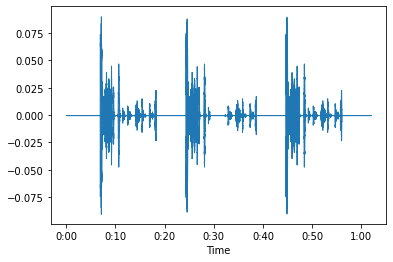

In [ ]:
fig, (ax) = plt.subplots(nrows=1, sharex=True)
#ax.set(title='Sample view', ylim=[-0.001, 0.001])
librosa.display.waveshow(y=y,sr=sr, marker='.', label='Full signal')

In [ ]:
test = librosa.effects.split(y)/sr

test
#Do we just smooth out the method
#Or do we find and 

array([[ 6.7570068 ,  9.93814059],
       [10.35609977, 11.14557823],
       [11.35455782, 11.9814966 ],
       [12.26013605, 13.35147392],
       [13.88553288, 16.18430839],
       [16.76480726, 17.78648526],
       [17.85614512, 18.29732426],
       [24.19519274, 27.37632653],
       [27.81750567, 28.58376417],
       [28.79274376, 29.2339229 ],
       [32.2060771 , 32.41505669],
       [32.69369615, 33.78503401],
       [34.34231293, 36.61786848],
       [37.19836735, 38.24326531],
       [38.31292517, 38.61478458],
       [44.53587302, 47.69378685],
       [48.13496599, 48.90122449],
       [49.11020408, 49.73714286],
       [50.01578231, 51.10712018],
       [51.66439909, 53.93995465],
       [54.52045351, 55.56535147],
       [55.63501134, 56.05297052]])

# Splicing clips based on sound

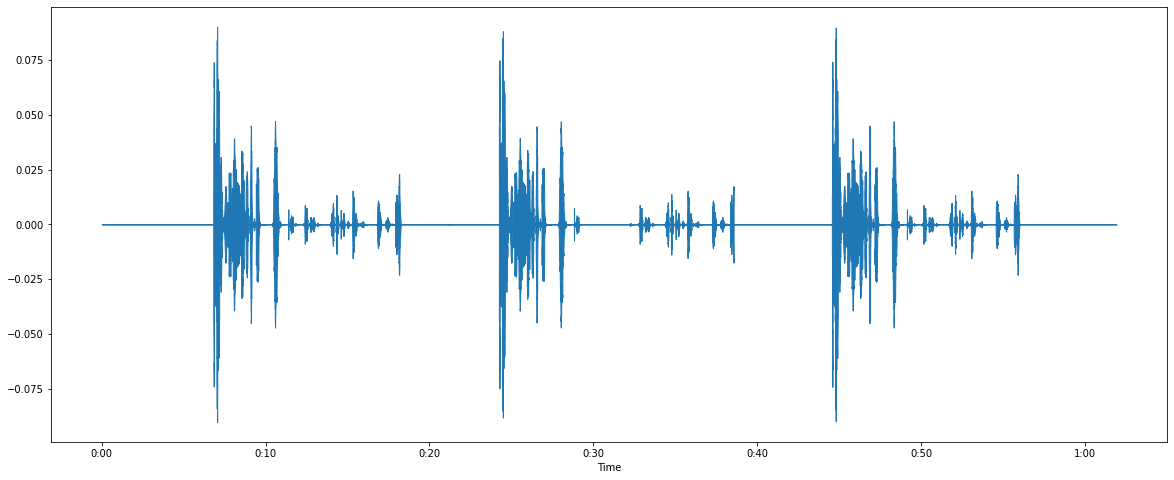

In [ ]:
fig, (ax) = plt.subplots(nrows=1, sharex=True,figsize = (20,8))
#ax.set(title='Sample view', ylim=[-0.001, 0.001])
librosa.display.waveshow(y=y,sr=sr, marker='.', label='Full signal')

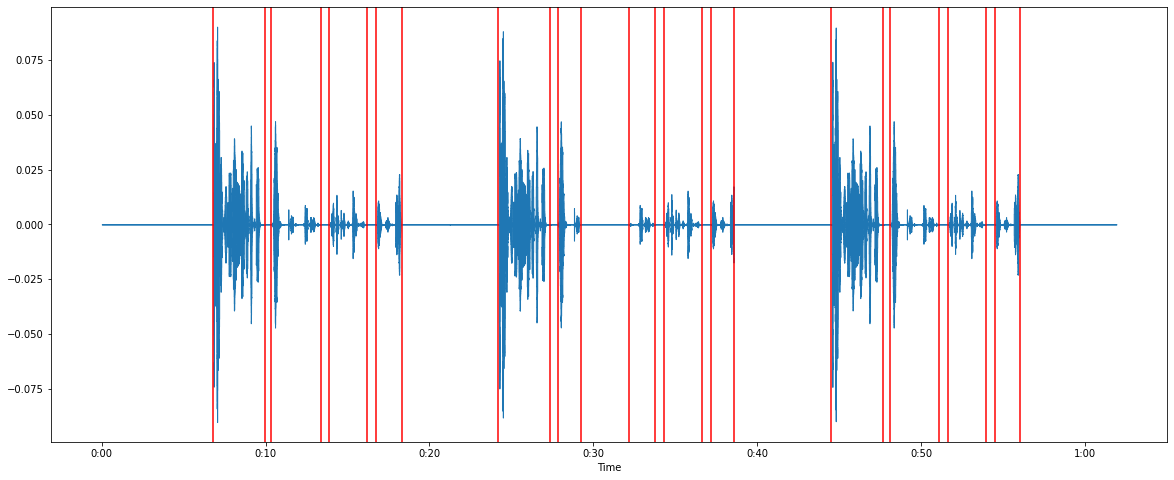

In [ ]:
x = test
#https://stackoverflow.com/questions/45844036/python-combine-array-rows-based-on-difference-between-prior-rows-last-element
start = x[1:, 0]  # select columns, ignoring the beginning of the first range
end = x[:-1, 1]  # and the end of the final range
mask = start>end+.3  # identify where consecutive rows have too great a gap
result = np.array([np.insert(start[mask], 0, x[0, 0]), np.append(end[mask], x[-1, -1])]).T


fig, (ax) = plt.subplots(nrows=1, sharex=True,figsize = (20,8))
#ax.set(title='Sample view', ylim=[-0.001, 0.001])
librosa.display.waveshow(y=y,sr=sr, marker='.')
for line in result.flatten():
  plt.axvline(x = line, color = 'r')

In [ ]:
result

array([[ 6.7570068 , 18.29732426],
       [24.19519274, 29.2339229 ],
       [32.2060771 , 38.61478458],
       [44.53587302, 56.05297052]])

# Changing Edited clips into smaller clips using FFMEP

In [ ]:
#things i want 
#https://www.linkedin.com/pulse/power-python-ffmpeg-story-2-detecting-commercial-blacks-ken-hansen/
#https://colab.research.google.com/github/yunooooo/FFmpeg-for-Google-Drive/blob/master/FFmpeg.ipynb#scrollTo=Sv8au_RO6WUs
#https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&color_mode=auto&commit=ac8d4994e24c9bc5b18044bce945f1590f7145c7&device=unknown&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6a656666686561746f6e2f70726573656e742f616338643439393465323463396263356231383034346263653934356631353930663731343563372f796f75747562652f766964656f2f636f6e766572745f766964656f5f62617369632e6970796e62&logged_in=false&nwo=jeffheaton%2Fpresent&path=youtube%2Fvideo%2Fconvert_video_basic.ipynb&platform=android&repository_id=66116261&repository_type=Repository&version=98


drive  sample_data


In [ ]:
def get_freeze_frames(path):
  #input: string of the path to the clip of interest
  #output: dataframe of all the start and stop times of the areas with freeze frames
  list_freeze_detect = !ffmpeg -i {path} -vf "crop=in_w:in_h:in_w:in_h/2, freezedetect=n=-60dB:d=1" -map 0:v:0 -f null - 2>&1 | grep freezedetect
  list_output=[]
  for item in list_freeze_detect:
    if 'freezedetect' in item:
      list_output.append(item)
  df_freeze_frames = pd.DataFrame(list_output,columns = ['full'])
  df_freeze_frames = df_freeze_frames.full.str.split(expand=True)
  df_freeze_frames = df_freeze_frames[df_freeze_frames[3].str.contains('start|end')==True]
  df_freeze_frames = df_freeze_frames.drop(columns = [1,2])
  df_freeze_frames.columns = ['type','start_end','timestamp']
  df_freeze_frames = df_freeze_frames.replace('lavfi.freezedetect.freeze_start:','start',regex = True)
  df_freeze_frames = df_freeze_frames.replace('lavfi.freezedetect.freeze_end:','end',regex = True)
  df_freeze_frames = df_freeze_frames.replace('\[freezedetect','freezedetect',regex = True)
  df_freeze_frames = pd.concat([df_freeze_frames[df_freeze_frames['start_end']=='start'].reset_index(drop=True),df_freeze_frames[df_freeze_frames['start_end']=='end'].reset_index(drop=True)], axis = 1)
  df_freeze_frames.columns = ['start_type', 'start', 'start_timestamp', 'end_type', 'end', 'end_timestamp']  
  return(df_freeze_frames)


def get_black_frames(path):
  list_black_detect = !ffmpeg -i {path} -vf "blackdetect=d=0.05:pix_th=0.10" -an -f null - 2>&1 | grep blackdetect
  list_output=[]
  for item in list_black_detect:
    if 'blackdetect' in item:
      list_output.append(item)
  df_black_screen = pd.DataFrame(list_output,columns = ['full'])
  df_black_screen = df_black_screen.full.str.split(expand=True)
  df_black_screen = df_black_screen.replace('\[blackdetect','blackdetect',regex = True)
  df_black_screen_start = df_black_screen[3].str.split(':',expand=True)
  df_black_screen_start.columns = ['start', 'start_timestamp']
  df_black_screen_end = df_black_screen[4].str.split(':',expand=True)
  df_black_screen_end.columns = ['end', 'end_timestamp']
  df_black_screen_out = pd.concat([df_black_screen_start.reset_index(drop=True),df_black_screen_end.reset_index(drop=True)], axis = 1)
  df_black_screen_out[['start_type','end_type']] = 'blackdetect','blackdetect'
  df_black_screen_out = df_black_screen_out.replace('black_end','end',regex = True)
  df_black_screen_out = df_black_screen_out.replace('black_start','start',regex = True)
  return(df_black_screen_out)

def get_ordered_freeze_black_frames(path):
  df_output = pd.concat([get_freeze_frames(path), get_black_frames(path)], axis=0)
  df_output = df_output.astype({'start_timestamp': 'float64','end_timestamp': 'float64'})
  df_output = df_output.sort_values(by='start_timestamp').reset_index(drop = True)
  df_output = df_output.groupby('start_timestamp').last()
  df_output['start_timestamp'] = df_output.index
  df_output = df_output.reset_index(drop = True)
  return df_output

def splice_clips(path,df):
  #@path: string of the path to the clip of interest
  #@df: dataframe from get_freeze_frames
  #this will splice the clips into areas of interest and output it in the spliced_clips folder
  row_max_index = df.shape[0] - 1
  clip_name = path.rsplit('/',2)[-1].rsplit('.')[0]
  splice_clips_dir = path.rsplit('/',1)[0] + '/spliced_clips'
  if not os.path.exists(splice_clips_dir):
    os.makedirs(splice_clips_dir)
  
  for index, row in df.iterrows():
    output_path = path.rsplit('/',1)[0] + '/spliced_clips/' + clip_name 
    next_index = index + 1
    if index == 0:
      continue
    if next_index > row_max_index:
      break
    if float(df.iloc[next_index].start_timestamp) - float(row.end_timestamp) < 1:
      continue
    start_split = str(row.end_timestamp)
    end_split = str(df.iloc[next_index].start_timestamp)
    if not os.path.exists(output_path):
      os.makedirs(output_path)
    output_file_path = output_path + '/'+ clip_name + '_raw_clip_example_' + str(index) + '.mp4'
    !ffmpeg -hide_banner -i {path} -ss {start_split} -to {end_split} -c copy {output_file_path}
    clear_output()

def splice_clips_new(path,df):
  #@path: string of the path to the clip of interest
  #@df: dataframe from get_freeze_frames
  #this will splice the clips into areas of interest and output it in the spliced_clips folder
  row_max_index = df.shape[0] - 1
  clip_name = path.rsplit('/',2)[-1].rsplit('.')[0]
  splice_clips_dir = path.rsplit('/',1)[0] + '/spliced_clips'
  if not os.path.exists(splice_clips_dir):
    os.makedirs(splice_clips_dir)
  for index, row in df.iterrows():
    output_path = path.rsplit('/',1)[0] + '/spliced_clips/' + clip_name 
    next_index = index + 1
    if next_index > row_max_index:
      break
    if (df.iloc[next_index].start_type == 'blackdetect' and row.start_type == 'freezedetect'):
      start_split = str(row.end_timestamp)
      end_split = str(df.iloc[next_index].start_timestamp)
      print('split here',start_split,end_split)
      if float(end_split) - float(start_split) <=1:
        continue
      if not os.path.exists(output_path):
        os.makedirs(output_path)
      output_file_path = output_path + '/'+ clip_name + '_raw_clip_example_' + str(index) + '.mp4'
      !ffmpeg -hide_banner -i {path} -ss {start_split} -to {end_split} -c copy {output_file_path}
      clear_output()

def get_dict_first_frames(path: str):
  #input: path to the directory that contains all the clips of interest
  #output: Dictionary of the name of the clip, and first image of the clip
  #uses this is to make the dictionary run the find_match_start function
  directory_splice_clips = path.rsplit('/',2)[0]
  list_clips = os.listdir(directory_splice_clips)
  first_frames = {}
  for clip in list_clips:
    if (first_frame_of_clip(directory_splice_clips + '/'+clip) is not None):
      first_frames[clip]=first_frame_of_clip(directory_splice_clips + '/'+clip)
  return first_frames

In [ ]:
path = "/content/drive/MyDrive/haber_research/test_data/elements/UI006ENM.mp4"

pd.concat([get_black_frames(path), get_freeze_frames(path)], axis=0).sort_values(by='start_timestamp').reset_index(drop = True)

#get_freeze_black_frames(path)

,start,start_timestamp,end,end_timestamp,start_type,end_type
0,start,1.2,end,2.64,freezedetect,freezedetect
1,start,14.16,end,17.16,blackdetect,blackdetect
2,start,14.16,end,17.16,freezedetect,freezedetect
3,start,18,end,20.2,freezedetect,freezedetect
4,start,24,end,26.6,freezedetect,freezedetect
5,start,3.36,end,6.6,freezedetect,freezedetect
6,start,30.2,end,31.2,freezedetect,freezedetect
7,start,31.2,end,33.16,freezedetect,freezedetect
8,start,33.16,end,36.16,blackdetect,blackdetect
9,start,33.16,end,36.16,freezedetect,freezedetect


In [ ]:
#%%timeit this is a bug in colab not sure now to report this to google
#from the 2 FIND Edited Clips
clip_edited_ESF = '/content/drive/MyDrive/haber_research/test_data'
dict_df = {}
for root, dirs, files in os.walk(clip_edited_ESF):
  for filename in files:
    if 'elements' in root:
      if 'spliced_clips' not in root:
        print(os.path.join(root, filename))
        dict_df[filename] = get_ordered_freeze_black_frames(os.path.join(root, filename))


pd.DataFrame([dict_df]).to_csv('/content/drive/MyDrive/haber_research/dict_df_savefile.csv')
#http://www.akpdev.com/articles/2014/11/24/batch-media-processing-ffmpeg-python.html parallel computing

/content/drive/MyDrive/haber_research/test_data/elements/WB033WEditedSupportingandEncouraging.mp4


In [ ]:
dict_df['WB033WEditedSupportingandEncouraging.mp4']

,start_type,start,end_type,end,end_timestamp,start_timestamp
0,freezedetect,start,freezedetect,end,2.96963,0.00000
1,freezedetect,start,freezedetect,end,20.55390,4.23757
2,freezedetect,start,freezedetect,end,36.80340,21.62160
3,freezedetect,start,freezedetect,end,44.64460,41.24120
4,freezedetect,start,freezedetect,end,48.38170,44.64460
5,freezedetect,start,freezedetect,end,54.28760,50.65060
6,freezedetect,start,freezedetect,end,63.63020,56.65660
7,blackdetect,start,blackdetect,end,66.39970,63.63020
8,freezedetect,start,freezedetect,end,80.88080,70.73730
9,blackdetect,start,blackdetect,end,87.28720,83.95050


In [ ]:
def splice_clips_test(path,df):
  #@path: string of the path to the clip of interest
  #@df: dataframe from get_freeze_frames
  #this will splice the clips into areas of interest and output it in the spliced_clips folder
  row_max_index = df.shape[0] - 1
  clip_name = path.rsplit('/',2)[-1].rsplit('.')[0]
  splice_clips_dir = path.rsplit('/',1)[0] + '/spliced_clips'
  if not os.path.exists(splice_clips_dir):
    os.makedirs(splice_clips_dir)
  for index, row in df.iterrows():
    output_path = path.rsplit('/',1)[0] + '/spliced_clips/' + clip_name 
    next_index = index + 1
    if next_index > row_max_index:
      break
    if (df.iloc[next_index].start_type == 'blackdetect' and row.start_type == 'freezedetect'):
      start_split = str(row.end_timestamp)
      end_split = str(df.iloc[next_index].start_timestamp)
      if float(end_split) - float(start_split) <= 1:
        continue
      print('split here',start_split,end_split, index)

x = dict_df['UI006EEB.mp4']
y = '/content/drive/MyDrive/haber_research/test_data/elements/UI006EEB.mp4'
splice_clips_test(y,x)

split here 6.4 26.84 2


In [ ]:
###testing
clip_edited_ESF = '/content/drive/MyDrive/haber_research/test_data/elements/'

for keys in dict_df.keys():
  path = clip_edited_ESF + keys
  splice_clips_test(path , dict_df[keys])

split here 80.8808 83.9505 8
split here 120.053 125.459 14


In [ ]:
#splice the video and folder
clip_edited_ESF = '/content/drive/MyDrive/haber_research/test_data/elements/'

for keys in dict_df.keys():
  path = clip_edited_ESF + keys
  splice_clips_new(path , dict_df[keys])



split here 149.282 149.282
split here 233.366 233.567


In [ ]:
#analyze the existing clips
path_clip_spliced = '/content/drive/MyDrive/haber_research/test_data/elements/spliced_clips'
list_out = []


for root, dirs, files in os.walk(clip_edited_ESF):
  for filename in files:
    dict_input = {}
    if 'spliced_clips' in root:
      dict_input['filename'] = filename
      holder_variable = !ffprobe -v error -show_entries format=duration -of default=noprint_wrappers=1:nokey=1 {os.path.join(root, filename)}
      dict_input['duration'] = float(holder_variable[0])
      list_out.append(dict_input)

df_element_clip = pd.DataFrame(list_out)

def apply_element(row):
  row = row.lower()
  if 'eeb' in row:
    return 'end_begin'
  elif 'ebf' in row:
    return 'back_forth'
  elif 'enm' in row:
    return 'naming'
  elif 'ese' in row:
    return 'support_encourage'
  elif 'esf' in row:
    return 'sharing_focus'


df_element_clip['element'] = df_element_clip.filename.apply(lambda x: apply_element(x))

df_element_clip.to_csv('/content/drive/MyDrive/haber_research/df_element_clip.csv')
df_element_clip

,filename,duration,element
0,UI007ESE_1of2_raw_clip_example_1.mp4,5.855,support_encourage
1,UI007ESE_2of2_raw_clip_example_1.mp4,11.167,support_encourage
2,UI007ENM_1of2_raw_clip_example_1.mp4,8.804,naming
3,UI007ENM_2of2_raw_clip_example_1.mp4,7.050,naming
4,UI007EBF_1of2_raw_clip_example_1.mp4,13.727,back_forth
5,UI007EBF_2of2_raw_clip_example_1.mp4,11.292,back_forth
6,UI007EEB_1of2_raw_clip_example_1.mp4,11.404,end_begin
7,UI007EEB_2of2_raw_clip_example_1.mp4,10.372,end_begin
8,UI006ENM_raw_clip_example_1.mp4,7.564,naming
9,UI006ESE_raw_clip_example_1.mp4,6.162,support_encourage


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


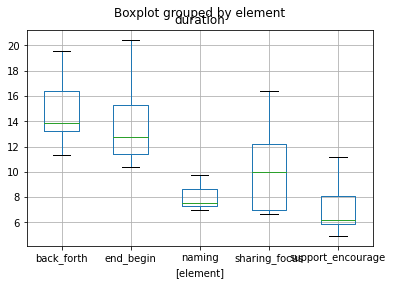

In [ ]:
df_element_clip.boxplot(by = 'element')